In [41]:
import numpy as np
import pandas as pd
from functions import *

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import plot_confusion_matrix, classification_report,accuracy_score, f1_score

# Scalers
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

# Categorical Create Dummies
from sklearn.preprocessing import OneHotEncoder

In [2]:
#notes for later:
#drop NA values across the board
#investigate object types
#investigate kepid vs kepoi_name

#disposition uses lightcurve data to finalize candidates into confirmed status
#remove other metrics already used to classify dispositions

In [3]:
# REMOVE - USED TO DETERMINE CLASSIFIERS
# koi_score
# koi_max_mult_ev
# flags?

In [4]:
# Kepler uses transit data to determine potential exo planets, further analysis is to finalize candidates
# plan of action - find thats related to transit data, remove the secondary tests done once a possible candidate is identified

# The Introduction

# EDA

In [5]:
df = pd.read_csv(r'Data\KeplerData.csv',skiprows=76)

In [6]:
import random
random.seed(45)

## Info Describe and Plots of Distributions

In [7]:
df.head()

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,...,-0.021,-0.038,0.00070,0.00060,-0.025,-0.034,0.042,0.002,-0.027,0.027
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-0.111,0.002,0.00302,-0.00142,-0.249,0.147,0.289,-0.257,0.099,0.276
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-0.010,0.230,0.00008,-0.00007,0.030,-0.090,0.100,0.070,0.020,0.070


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 70 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   kepid              9564 non-null   int64  
 1   kepoi_name         9564 non-null   object 
 2   kepler_name        2365 non-null   object 
 3   koi_disposition    9564 non-null   object 
 4   koi_pdisposition   9564 non-null   object 
 5   koi_score          8054 non-null   float64
 6   koi_fpflag_nt      9564 non-null   int64  
 7   koi_fpflag_ss      9564 non-null   int64  
 8   koi_fpflag_co      9564 non-null   int64  
 9   koi_fpflag_ec      9564 non-null   int64  
 10  koi_disp_prov      9564 non-null   object 
 11  koi_period         9564 non-null   float64
 12  koi_time0bk        9564 non-null   float64
 13  koi_time0          9564 non-null   float64
 14  koi_eccen          9201 non-null   float64
 15  koi_longp          0 non-null      float64
 16  koi_impact         9201 

In [9]:
df.describe()

,kepid,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_time0bk,koi_time0,koi_eccen,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
count,9.564000e+03,8054.000000,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000,9.564000e+03,9201.0,...,9109.000000,9109.000000,8734.000000,8747.000000,8965.000000,8965.000000,8965.000000,8994.000000,8994.000000,8994.000000
mean,7.690628e+06,0.480829,0.208595,0.232748,0.197512,0.120033,75.671358,166.183251,2.454999e+06,0.0,...,-0.316136,-0.165817,-0.000097,-0.000714,-0.012281,-0.045420,1.866561,-0.024244,-0.076749,1.812566
std,2.653459e+06,0.476928,4.767290,0.422605,0.398142,0.325018,1334.744046,67.918960,6.791896e+01,0.0,...,20.254777,20.534655,0.058225,0.092987,2.406550,2.573558,2.988742,2.382286,2.553758,2.986376
min,7.574500e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.241843,120.515914,2.454954e+06,0.0,...,-742.430000,-417.900000,-4.000000,-6.000000,-25.100000,-75.900000,0.000000,-27.800000,-76.600000,0.000000
25%,5.556034e+06,0.000000,0.000000,0.000000,0.000000,0.000000,2.733684,132.761718,2.454966e+06,0.0,...,-0.600000,-0.680000,-0.000210,-0.000220,-0.320000,-0.387000,0.170000,-0.310000,-0.390000,0.210000
50%,7.906892e+06,0.334000,0.000000,0.000000,0.000000,0.000000,9.752831,137.224595,2.454970e+06,0.0,...,-0.000500,-0.034000,0.000000,0.000000,0.000000,0.000000,0.610000,-0.004000,-0.017000,0.583000
75%,9.873066e+06,0.998000,0.000000,0.000000,0.000000,0.000000,40.715178,170.694603,2.455004e+06,0.0,...,0.570000,0.500000,0.000240,0.000240,0.309000,0.300000,2.160000,0.290000,0.300000,1.970000
max,1.293514e+07,1.000000,465.000000,1.000000,1.000000,1.000000,129995.778400,1472.522306,2.456306e+06,0.0,...,549.500000,712.500000,1.190000,5.000000,45.680000,27.500000,88.600000,46.570000,34.000000,89.600000


In [10]:
df.koi_pdisposition.value_counts()

FALSE POSITIVE    4847
CANDIDATE         4717
Name: koi_pdisposition, dtype: int64

In [11]:
(df.koi_disposition == df.koi_pdisposition).value_counts()

True     7200
False    2364
dtype: int64

In [12]:
df_FP = df.loc[df.koi_disposition == "FALSE POSITIVE"]

In [13]:
(df_FP.koi_disposition == df_FP.koi_pdisposition).value_counts()

True     4839
False       1
dtype: int64

In [14]:
for col in df.columns:
    print(df[col].isna().value_counts())

False    9564
Name: kepid, dtype: int64
False    9564
Name: kepoi_name, dtype: int64
True     7199
False    2365
Name: kepler_name, dtype: int64
False    9564
Name: koi_disposition, dtype: int64
False    9564
Name: koi_pdisposition, dtype: int64
False    8054
True     1510
Name: koi_score, dtype: int64
False    9564
Name: koi_fpflag_nt, dtype: int64
False    9564
Name: koi_fpflag_ss, dtype: int64
False    9564
Name: koi_fpflag_co, dtype: int64
False    9564
Name: koi_fpflag_ec, dtype: int64
False    9564
Name: koi_disp_prov, dtype: int64
False    9564
Name: koi_period, dtype: int64
False    9564
Name: koi_time0bk, dtype: int64
False    9564
Name: koi_time0, dtype: int64
False    9201
True      363
Name: koi_eccen, dtype: int64
True    9564
Name: koi_longp, dtype: int64
False    9201
True      363
Name: koi_impact, dtype: int64
False    9564
Name: koi_duration, dtype: int64
True    9564
Name: koi_ingress, dtype: int64
False    9201
True      363
Name: koi_depth, dtype: int64
False    92

## Drop obvious columns (ID etc) and rows of missing data

### Initial Column Drop

In [15]:
len(df.columns)

70

In [16]:
df.head()

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,...,-0.021,-0.038,0.00070,0.00060,-0.025,-0.034,0.042,0.002,-0.027,0.027
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-0.111,0.002,0.00302,-0.00142,-0.249,0.147,0.289,-0.257,0.099,0.276
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-0.010,0.230,0.00008,-0.00007,0.030,-0.090,0.100,0.070,0.020,0.070


In [17]:
drop_initial = ['kepid','kepoi_name','kepler_name','koi_ingress','koi_longp','koi_sage']

In [18]:
df_initial_drop = df.drop(drop_initial,axis=1)

In [19]:
df_initial_drop.head()

,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_disp_prov,koi_period,koi_time0bk,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,CONFIRMED,CANDIDATE,1.000,0,0,0,0,q1_q17_dr25_sup_koi,9.488036,170.538750,...,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
1,CONFIRMED,CANDIDATE,0.969,0,0,0,0,q1_q17_dr25_sup_koi,54.418383,162.513840,...,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
2,CANDIDATE,CANDIDATE,0.000,0,0,0,0,q1_q17_dr25_sup_koi,19.899140,175.850252,...,-0.021,-0.038,0.00070,0.00060,-0.025,-0.034,0.042,0.002,-0.027,0.027
3,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,q1_q17_dr25_sup_koi,1.736952,170.307565,...,-0.111,0.002,0.00302,-0.00142,-0.249,0.147,0.289,-0.257,0.099,0.276
4,CONFIRMED,CANDIDATE,1.000,0,0,0,0,q1_q17_dr25_sup_koi,2.525592,171.595550,...,-0.010,0.230,0.00008,-0.00007,0.030,-0.090,0.100,0.070,0.020,0.070


### Drop rows of missing data

In [20]:
for col in df_initial_drop.columns:
    print(df_initial_drop[col].isna().value_counts())

False    9564
Name: koi_disposition, dtype: int64
False    9564
Name: koi_pdisposition, dtype: int64
False    8054
True     1510
Name: koi_score, dtype: int64
False    9564
Name: koi_fpflag_nt, dtype: int64
False    9564
Name: koi_fpflag_ss, dtype: int64
False    9564
Name: koi_fpflag_co, dtype: int64
False    9564
Name: koi_fpflag_ec, dtype: int64
False    9564
Name: koi_disp_prov, dtype: int64
False    9564
Name: koi_period, dtype: int64
False    9564
Name: koi_time0bk, dtype: int64
False    9564
Name: koi_time0, dtype: int64
False    9201
True      363
Name: koi_eccen, dtype: int64
False    9201
True      363
Name: koi_impact, dtype: int64
False    9564
Name: koi_duration, dtype: int64
False    9201
True      363
Name: koi_depth, dtype: int64
False    9201
True      363
Name: koi_ror, dtype: int64
False    9243
True      321
Name: koi_srho, dtype: int64
False    9564
Name: koi_fittype, dtype: int64
False    9201
True      363
Name: koi_prad, dtype: int64
False    9201
True      363


In [21]:
df_initial_drop = df_initial_drop.dropna(subset=['koi_score','koi_quarters','koi_fwm_stat_sig','koi_dicco_mra','koi_model_snr','koi_zmag','koi_fwm_sra','koi_smet','koi_gmag','koi_rmag','koi_imag'], how='any')

In [22]:
for col in df_initial_drop.columns:
    print(df_initial_drop[col].isna().value_counts())

False    6682
Name: koi_disposition, dtype: int64
False    6682
Name: koi_pdisposition, dtype: int64
False    6682
Name: koi_score, dtype: int64
False    6682
Name: koi_fpflag_nt, dtype: int64
False    6682
Name: koi_fpflag_ss, dtype: int64
False    6682
Name: koi_fpflag_co, dtype: int64
False    6682
Name: koi_fpflag_ec, dtype: int64
False    6682
Name: koi_disp_prov, dtype: int64
False    6682
Name: koi_period, dtype: int64
False    6682
Name: koi_time0bk, dtype: int64
False    6682
Name: koi_time0, dtype: int64
False    6682
Name: koi_eccen, dtype: int64
False    6682
Name: koi_impact, dtype: int64
False    6682
Name: koi_duration, dtype: int64
False    6682
Name: koi_depth, dtype: int64
False    6682
Name: koi_ror, dtype: int64
False    6682
Name: koi_srho, dtype: int64
False    6682
Name: koi_fittype, dtype: int64
False    6682
Name: koi_prad, dtype: int64
False    6682
Name: koi_sma, dtype: int64
False    6682
Name: koi_incl, dtype: int64
False    6682
Name: koi_teq, dtype: int64

In [23]:
len(df_initial_drop.columns)

64

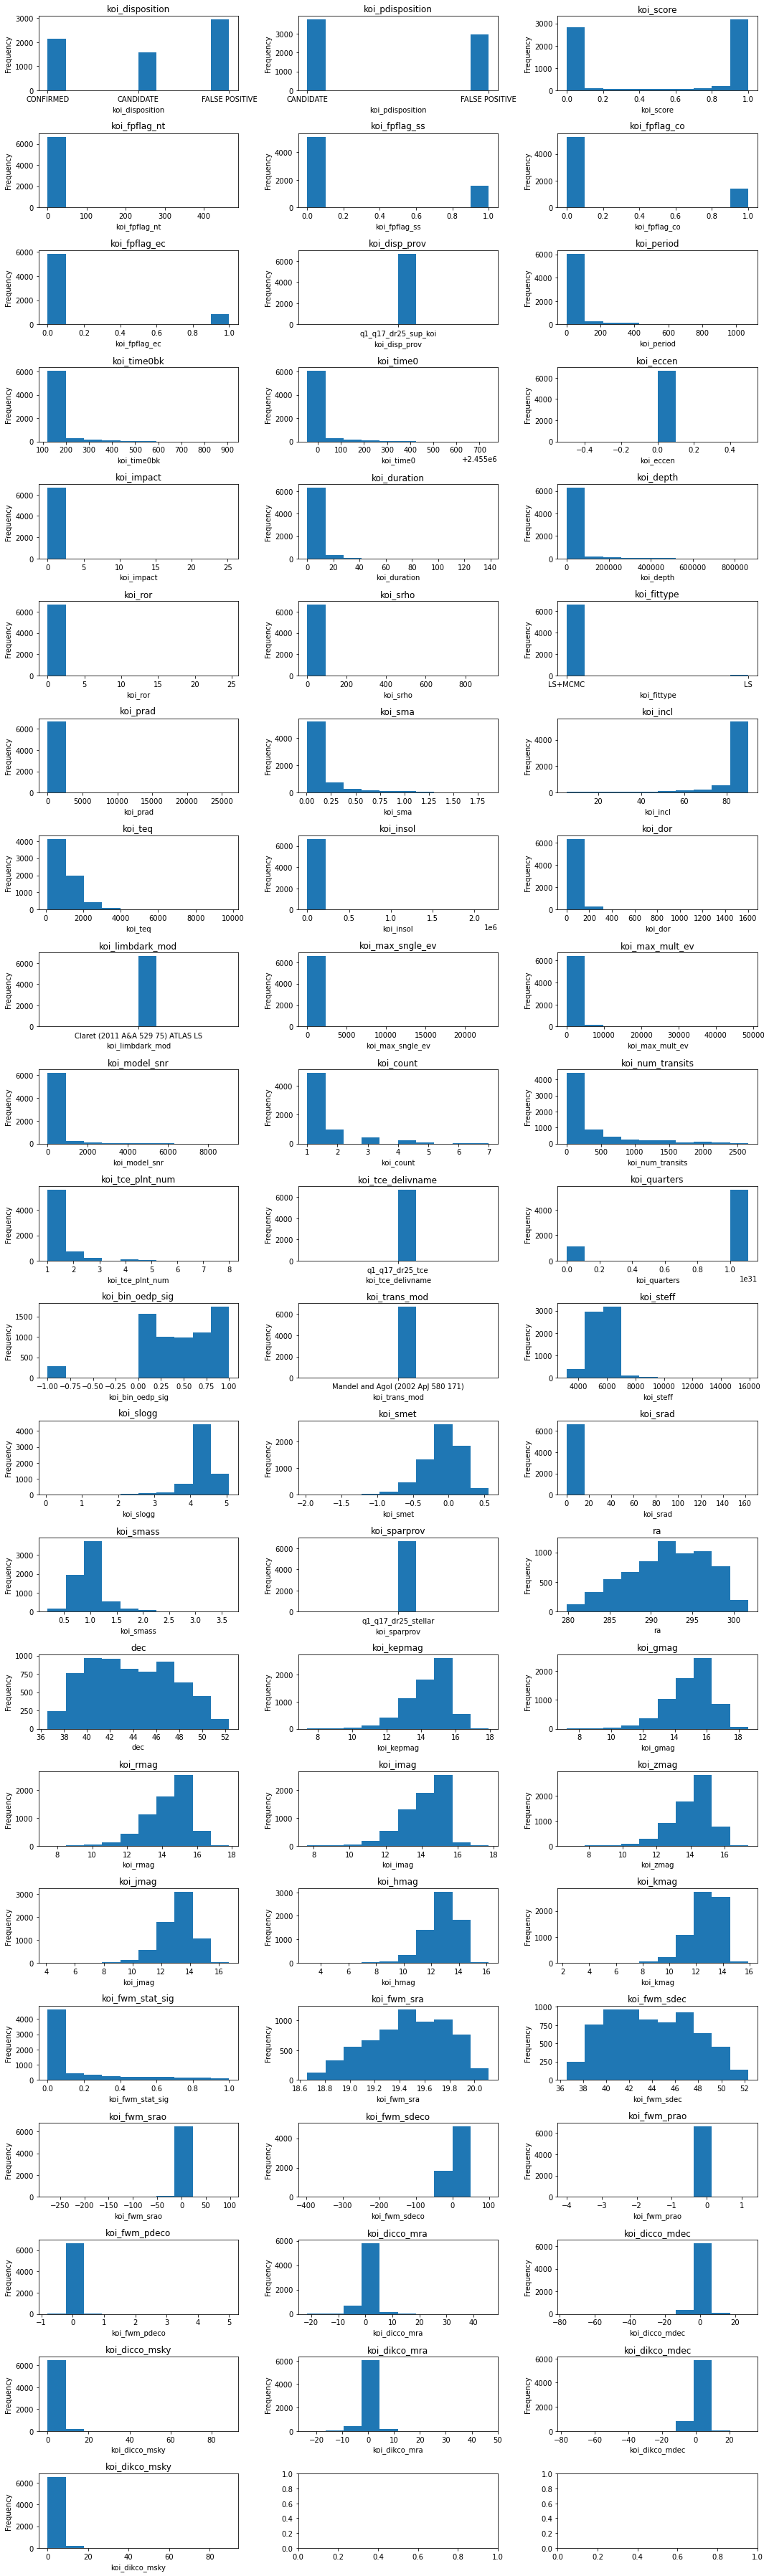

In [24]:
fig, axes = plt.subplots(figsize=(15,50),nrows=22,ncols=3)
for i in range(len(df_initial_drop.columns)):
    row = i%3
    col = i//3
    axis = axes[col,row]
    axis.hist(df_initial_drop[df_initial_drop.columns[i]])
    axis.set_title(df_initial_drop.columns[i])
    axis.set_xlabel(df_initial_drop.columns[i])
    axis.set_ylabel("Frequency")
    plt.tight_layout()

In [25]:
add_drops = ['koi_sparprov','koi_trans_mod','koi_tce_delivname','koi_limbdark_mod','koi_fittype','koi_disp_prov']
df_initial_drop = df_initial_drop.drop(add_drops,axis=1)

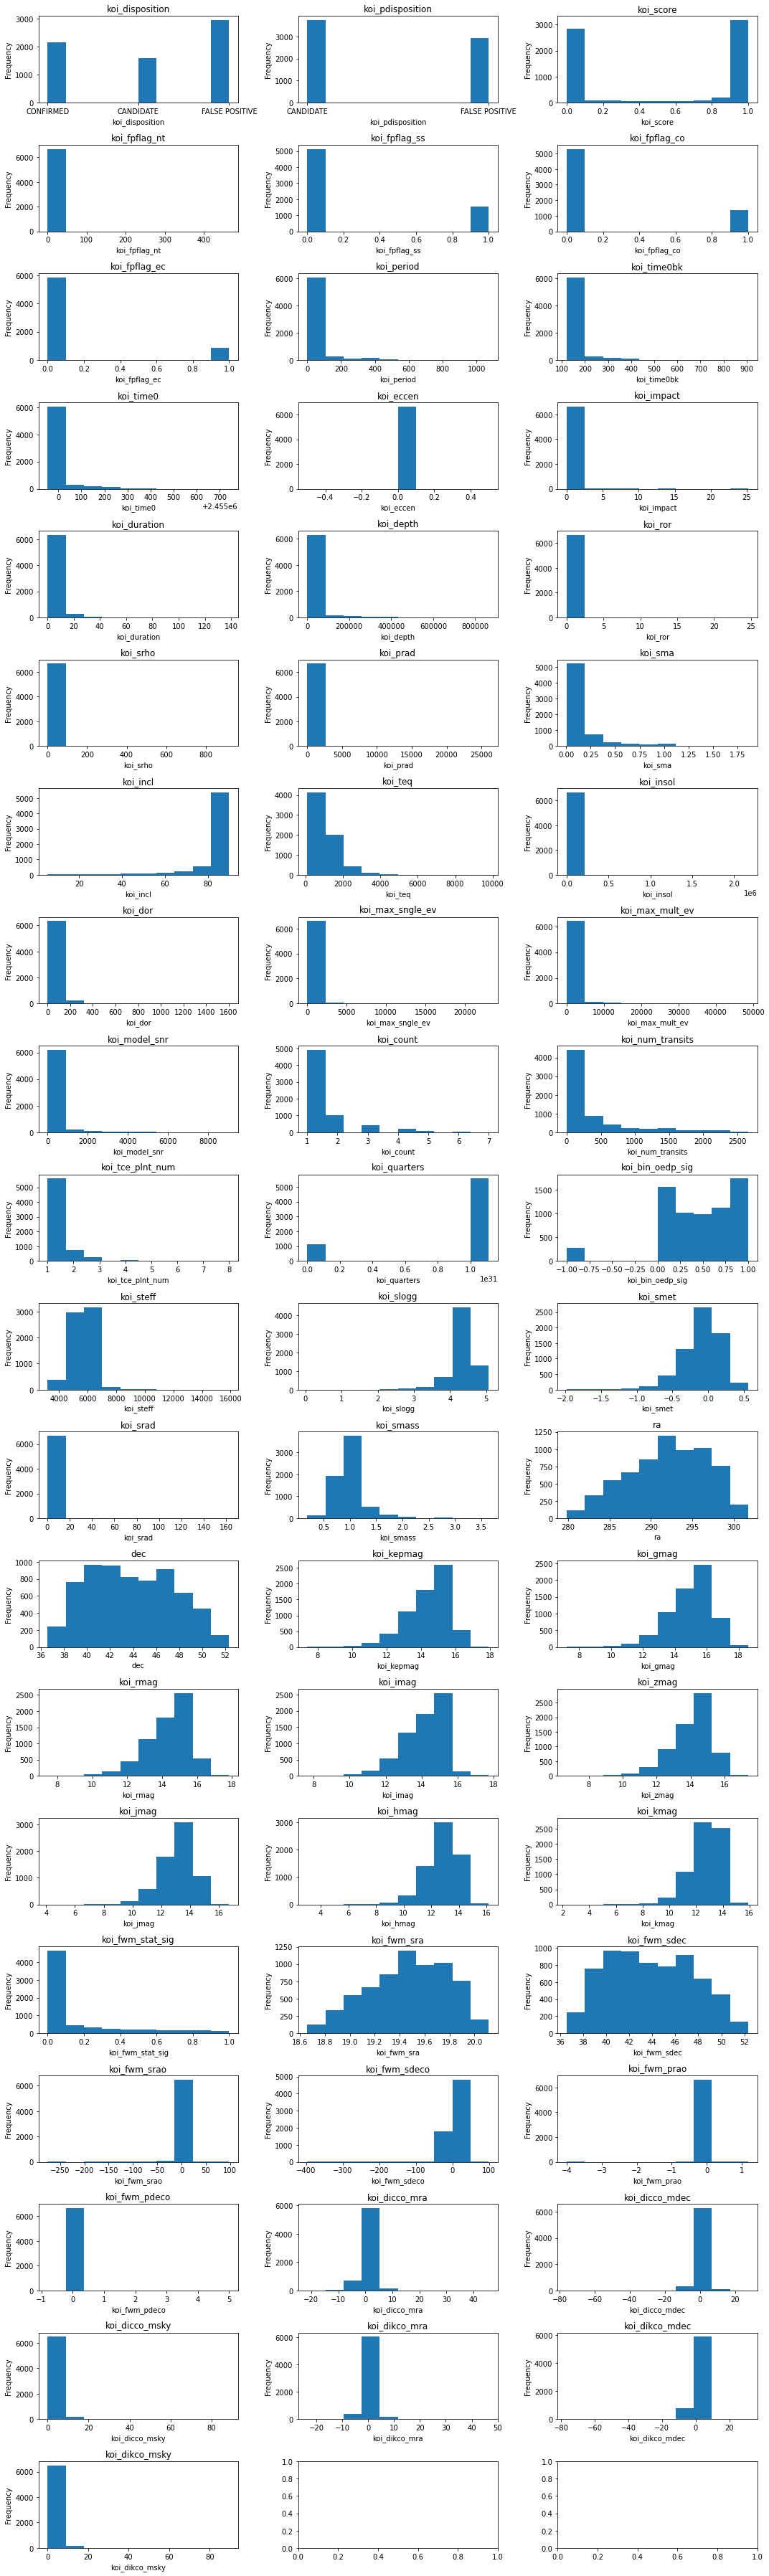

In [26]:
fig, axes = plt.subplots(figsize=(15,50),nrows=20,ncols=3)
for i in range(len(df_initial_drop.columns)):
    row = i%3
    col = i//3
    axis = axes[col,row]
    axis.hist(df_initial_drop[df_initial_drop.columns[i]])
    axis.set_title(df_initial_drop.columns[i])
    axis.set_xlabel(df_initial_drop.columns[i])
    axis.set_ylabel("Frequency")
    plt.tight_layout()

In [27]:
df_initial_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6682 entries, 0 to 9563
Data columns (total 58 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   koi_disposition   6682 non-null   object 
 1   koi_pdisposition  6682 non-null   object 
 2   koi_score         6682 non-null   float64
 3   koi_fpflag_nt     6682 non-null   int64  
 4   koi_fpflag_ss     6682 non-null   int64  
 5   koi_fpflag_co     6682 non-null   int64  
 6   koi_fpflag_ec     6682 non-null   int64  
 7   koi_period        6682 non-null   float64
 8   koi_time0bk       6682 non-null   float64
 9   koi_time0         6682 non-null   float64
 10  koi_eccen         6682 non-null   float64
 11  koi_impact        6682 non-null   float64
 12  koi_duration      6682 non-null   float64
 13  koi_depth         6682 non-null   float64
 14  koi_ror           6682 non-null   float64
 15  koi_srho          6682 non-null   float64
 16  koi_prad          6682 non-null   float64


# Build initial model with pipeline and log regression

## Train Test Data

In [28]:
X = df_initial_drop.drop(['koi_disposition','koi_pdisposition'],axis=1)
y = df_initial_drop['koi_disposition']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Initial Pipleline Model

In [30]:
initial_pipeline = Pipeline([('ss', StandardScaler()),
                            ('log',LogisticRegression())])

********************************************************

     Classification Report: Train

                precision    recall  f1-score   support

     CANDIDATE       0.77      0.66      0.71      1266
     CONFIRMED       0.78      0.86      0.82      1742
FALSE POSITIVE       0.99      0.99      0.99      2337

      accuracy                           0.87      5345
     macro avg       0.85      0.84      0.84      5345
  weighted avg       0.87      0.87      0.87      5345

********************************************************

     Classification Report: Test

                precision    recall  f1-score   support

     CANDIDATE       0.76      0.64      0.70       323
     CONFIRMED       0.77      0.85      0.81       413
FALSE POSITIVE       0.99      0.99      0.99       601

      accuracy                           0.86      1337
     macro avg       0.84      0.83      0.83      1337
  weighted avg       0.86      0.86      0.86      1337

*************************

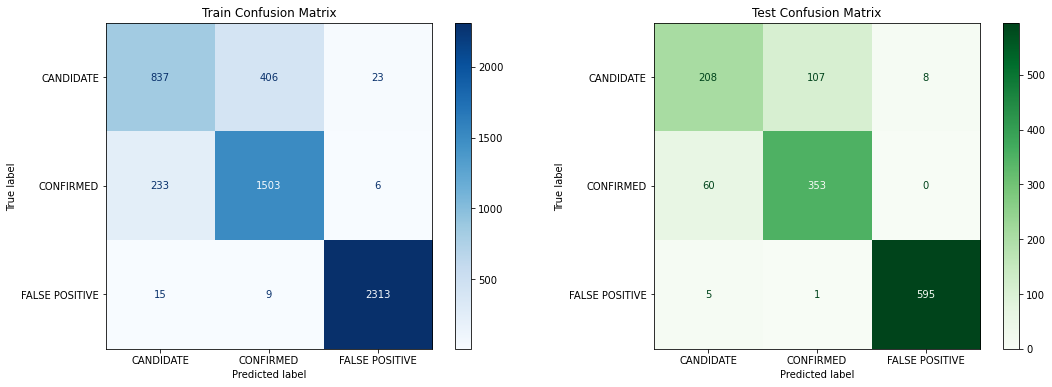

In [31]:
initial_model = run_class_model(initial_pipeline, X_train, y_train, X_test, y_test)

### Initial Findings/Results

* Performs well for an initial model, primarily looking for accuracy
* Model is able to predict False Positives too well.  After further investigation, there are columns included in the model
  which are already used to calculate the disposition (target variable) and should be removed

# Calculator Features Removal and Initial Model Rebuild

In [32]:
X.columns

Index(['koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co',
       'koi_fpflag_ec', 'koi_period', 'koi_time0bk', 'koi_time0', 'koi_eccen',
       'koi_impact', 'koi_duration', 'koi_depth', 'koi_ror', 'koi_srho',
       'koi_prad', 'koi_sma', 'koi_incl', 'koi_teq', 'koi_insol', 'koi_dor',
       'koi_max_sngle_ev', 'koi_max_mult_ev', 'koi_model_snr', 'koi_count',
       'koi_num_transits', 'koi_tce_plnt_num', 'koi_quarters',
       'koi_bin_oedp_sig', 'koi_steff', 'koi_slogg', 'koi_smet', 'koi_srad',
       'koi_smass', 'ra', 'dec', 'koi_kepmag', 'koi_gmag', 'koi_rmag',
       'koi_imag', 'koi_zmag', 'koi_jmag', 'koi_hmag', 'koi_kmag',
       'koi_fwm_stat_sig', 'koi_fwm_sra', 'koi_fwm_sdec', 'koi_fwm_srao',
       'koi_fwm_sdeco', 'koi_fwm_prao', 'koi_fwm_pdeco', 'koi_dicco_mra',
       'koi_dicco_mdec', 'koi_dicco_msky', 'koi_dikco_mra', 'koi_dikco_mdec',
       'koi_dikco_msky'],
      dtype='object')

In [33]:
c_features = ['koi_score','koi_max_mult_ev','koi_fpflag_nt','koi_fpflag_ss','koi_fpflag_co','koi_fpflag_ec']
df_revised = df_initial_drop.drop(c_features,axis=1)

## Train Test Data Rebuilt

In [34]:
X_r = df_revised.drop(['koi_disposition','koi_pdisposition'],axis=1)
y_r = df_revised['koi_disposition']

In [35]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_r, y_r, test_size=0.2)

## Remodel

In [39]:
remodel_pipeline = Pipeline([('ss', StandardScaler()),
                            ('log',LogisticRegression())])

********************************************************

     Classification Report: Train

                precision    recall  f1-score   support

     CANDIDATE       0.65      0.54      0.59      1271
     CONFIRMED       0.76      0.88      0.81      1713
FALSE POSITIVE       0.92      0.90      0.91      2361

      accuracy                           0.81      5345
     macro avg       0.78      0.77      0.77      5345
  weighted avg       0.80      0.81      0.80      5345

********************************************************

     Classification Report: Test

                precision    recall  f1-score   support

     CANDIDATE       0.64      0.48      0.55       318
     CONFIRMED       0.73      0.86      0.79       442
FALSE POSITIVE       0.92      0.92      0.92       577

      accuracy                           0.80      1337
     macro avg       0.76      0.75      0.75      1337
  weighted avg       0.79      0.80      0.79      1337

*************************

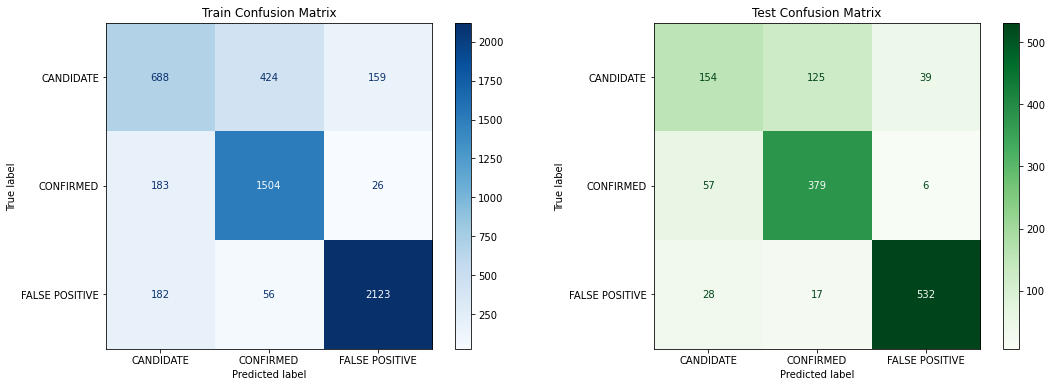

In [40]:
remodel = run_class_model(remodel_pipeline, X_train_r, y_train_r, X_test_r, y_test_r)

### Remodeled Findings

* Model performed worse overall which was expected

# List of models
* Logistic Regression
* K Nearest Neighbors
* Gaussian Naive Bayes
* Random Forest
* ADA Boost
* Gradient Boost
* XG Boost

## Model 1 - Logistic Regression

### Gridsearch Tuning

In [ ]:
#grid = [{RF__max_depth: [4,5],
#            'RF__min_samples_split': [5,10],
#            'RF__min_samples_leaf': [3,5]}]

#gridsearchmodel = GridSearchCV(estimator=log_pipe,
#                                param_grid=grid,
#                                scoring='accuracy',
#                                cv=5)

In [43]:
log_pipe = Pipeline([('ss', StandardScaler()),
                     ('log', LogisticRegression())])
log_grid = [{'log__C': [0,10],
             'log__solver': ['newton-cg','sag','saga','lbfgs']}]

In [45]:
log_gridsearch = GridSearchCV(estimator=log_pipe,
                              param_grid=log_grid,
                              scoring='accuracy',
                              cv=5)

********************************************************

     Classification Report: Train

                precision    recall  f1-score   support

     CANDIDATE       0.65      0.55      0.59      1271
     CONFIRMED       0.76      0.88      0.81      1713
FALSE POSITIVE       0.92      0.90      0.91      2361

      accuracy                           0.81      5345
     macro avg       0.78      0.77      0.77      5345
  weighted avg       0.81      0.81      0.80      5345

********************************************************

     Classification Report: Test

                precision    recall  f1-score   support

     CANDIDATE       0.63      0.48      0.55       318
     CONFIRMED       0.72      0.85      0.78       442
FALSE POSITIVE       0.92      0.92      0.92       577

      accuracy                           0.79      1337
     macro avg       0.76      0.75      0.75      1337
  weighted avg       0.79      0.79      0.79      1337

*************************

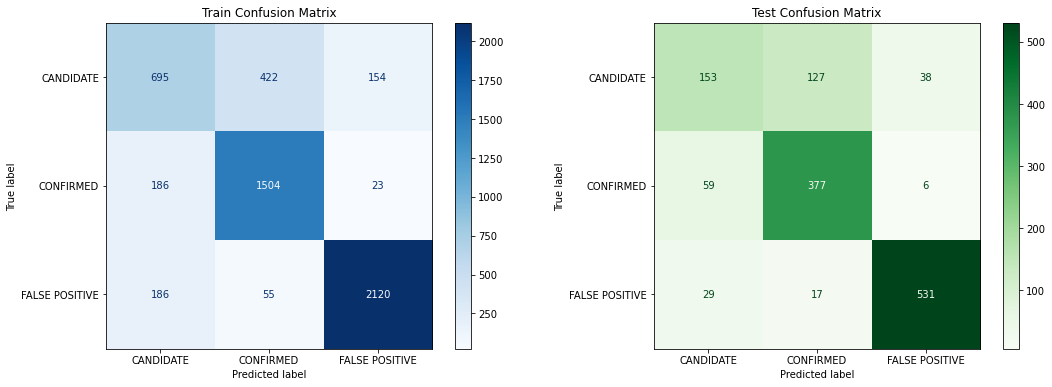

In [46]:
gslog_model = run_class_model(log_gridsearch, X_train_r, y_train_r, X_test_r, y_test_r)

In [47]:
gslog_model.best_params_

{'log__C': 10, 'log__solver': 'lbfgs'}

In [50]:
accuracy_score(y_r, gslog_model.predict(X_r))

0.8051481592337624

### Insert each into gridsearch cv

## Table of Classification Results

In [52]:
all_models = [gslog_model] #add new model names here
model_names = ['Logistic Regression',
               'K Nearest Neighbors',
               'Gaussian Naive Bayes',
               'Random Forest',
               'ADA Boost',
               'Gradient Boost',
               'XG Boost']

In [53]:
# for i in range(len(model_names)):
#     print(model_names[m],':',accuracy_score(y_r, all_models[m].predict(X_r)))

SyntaxError: unexpected EOF while parsing (<ipython-input-53-1634d3fff45c>, line 2)

### Why the model works best, why were the metrics important

# Rerun Best Model plus reports

# Most important features

## RePlot the distrubutions and relationship with the target variable

# Examples for obtaining feature  importances

In [36]:
# scaled_pipeline2_model[1].feature_importances_

In [37]:
# d = {'Stats':X.columns,'FI':scaled_pipeline2_model[1].feature_importances_}
# d2 = pd.DataFrame(d)

In [38]:
# d2.sort_values(by='FI')